# Kaggle - Trending Products Weekly


- Validation on last on week:
    - MAP@12: 0.02554321196726997
    - test private : 0.02165
    - test public : 0.02137



- References:
    - https://www.kaggle.com/code/byfone/h-m-trending-products-weekly
    - https://www.kaggle.com/code/hervind/h-m-faster-trending-products-weekly/notebook
    - https://www.kaggle.com/code/byfone/h-m-purchases-in-a-row/notebook




In [1]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.optimize import curve_fit
from joblib import dump, load


import sys
sys.path.insert(0, '../')

from utils.preprocess import *
from utils.evaluate import mapk, apk


In [2]:

folder = '../../../h-and-m-recommender/data/'

art_df = pd.read_csv(os.path.join(folder, "articles.csv"))
cus_df = pd.read_csv(os.path.join(folder, "customers.csv"))
trans_df = pd.read_csv(os.path.join(folder, "transactions_train.csv"))

trans_df = make_weeknum_col(trans_df)
# week_num 0 is latest week of the transaction
train_df, val_df = split_train_valid(trans_df, 0)
# val_df = valid2submission(val_df)

train_df['t_dat'] = pd.to_datetime(train_df.t_dat)
val_df['t_dat'] = pd.to_datetime(val_df.t_dat)


/var/folders/fl/l7bfgt6j3lz29pwdkr0_537r0000gn/T/ipykernel_8386/2555159546.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['t_dat'] = pd.to_datetime(train_df.t_dat)
/var/folders/fl/l7bfgt6j3lz29pwdkr0_537r0000gn/T/ipykernel_8386/2555159546.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['t_dat'] = pd.to_datetime(val_df.t_dat)


In [3]:

# gb: (고객, 제품)별 날짜에 unique한 거래 횟수
# inx: 2번 이상 거래된 (고객, 제품)인덱스
gb = train_df.groupby(['customer_id', 'article_id'])['t_dat'].nunique()
inx = gb[gb>1].index

# rp_train_df: 2번 이상 거래된 
rp_train_df = train_df.set_index(['customer_id', 'article_id'])
rp_train_df = rp_train_df.loc[inx].copy().sort_index()

rp_train_df['shift_dat'] = rp_train_df.groupby(level=[0,1])['t_dat'].shift(1)
rp_train_df['dist'] = (rp_train_df['t_dat'] - rp_train_df['shift_dat']).dt.days
dist = rp_train_df.loc[rp_train_df['dist'].notna(), 'dist'].values



In [4]:
vc = rp_train_df['dist'].value_counts()
display(vc.head())
# 하루 이상의 제품-고객 거래의 시간 간격 개수 
vc = vc[1:]
display(vc.head())


0.0    442595
1.0    133620
2.0    130443
3.0    105650
4.0     82815
Name: dist, dtype: int64

1.0    133620
2.0    130443
3.0    105650
4.0     82815
5.0     63829
Name: dist, dtype: int64

- line fitting on 
    - ${{a}\over{\sqrt{x}}} + b\exp(-c x) + d$

- 저자 설명: This value allows us to take into account the dependence of the probability of a repeat purchase on the number of days that have passed since the previous purchase of this product.
    - 이전 구매와의 시간 간격에 대한 반복 구매 확률을 고려할 수 있다.
    - 위 통계량을 likelihood로 사용하는 것 같다
- https://www.kaggle.com/code/byfone/h-m-trending-products-weekly/comments

/Users/nys/miniforge3/envs/torch/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/Users/nys/miniforge3/envs/torch/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/Users/nys/miniforge3/envs/torch/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/Users/nys/miniforge3/envs/torch/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


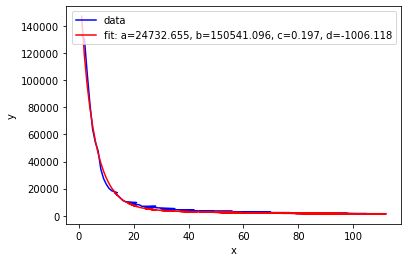

In [5]:
def func(x, a, b, c, d):
    return a / np.sqrt(x) + b * np.exp(-c*x) + d
# vc.index : 재구매 일수
# vc.values : 재구매 일수 별 횟수
popt, pcov = curve_fit(func, vc.index, vc.values)

plt.plot(vc.index[:100], vc.values[:100], 'b-', label='data')
plt.plot(vc.index[:100], func(vc.index[:100], *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [6]:
N = 12

last_ts = train_df['t_dat'].max()

tmp = train_df[['t_dat']].copy()
# day of week
tmp['dow'] = tmp['t_dat'].dt.dayofweek
#  Monday=0, ... ,Sunday=6

# last day of billing week
tmp['ldbw'] = tmp['t_dat'] - pd.TimedeltaIndex(tmp['dow'] - 1, unit='D')

tmp.loc[tmp['dow'] >=2, 'ldbw'] = tmp.loc[tmp['dow'] >=2 , 'ldbw'] + \
                        pd.TimedeltaIndex(np.ones(len(tmp.loc[tmp['dow'] >=2])) * 7, unit='D')



In [7]:
# 아래와 같이 마지막 날짜를 기준으로 1주일 설정
tmp.drop_duplicates().tail(10)


,t_dat,dow,ldbw
31183483,2020-09-06,6,2020-09-08
31218444,2020-09-07,0,2020-09-08
31256357,2020-09-08,1,2020-09-08
31292772,2020-09-09,2,2020-09-15
31334398,2020-09-10,3,2020-09-15
31374659,2020-09-11,4,2020-09-15
31412220,2020-09-12,5,2020-09-15
31452491,2020-09-13,6,2020-09-15
31492019,2020-09-14,0,2020-09-15
31521960,2020-09-15,1,2020-09-15


In [8]:
train_df['ldbw'] = tmp['ldbw'].values

weekly_sales = train_df.drop('customer_id', axis=1)\
                       .groupby(['ldbw', 'article_id'])\
                       .count().reset_index()
weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})
weekly_sales = weekly_sales[['ldbw', 'article_id', 'count']]


train_df = train_df.merge(weekly_sales, on=['ldbw', 'article_id'], how = 'left')



/var/folders/fl/l7bfgt6j3lz29pwdkr0_537r0000gn/T/ipykernel_8386/1010821190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['ldbw'] = tmp['ldbw'].values


In [9]:
# ldbw - 상품 - 팔린 횟수
weekly_sales.head()

,ldbw,article_id,count
0,2018-09-25,108775015,224
1,2018-09-25,108775044,96
2,2018-09-25,108775051,31
3,2018-09-25,110065001,28
4,2018-09-25,110065002,14


In [10]:

weekly_sales = weekly_sales.reset_index().set_index('article_id')

# 마지막주 상품의 팔린 횟수를 count_targ으로 설정
last_week_sales = weekly_sales.loc[weekly_sales['ldbw']==last_ts, ['count']]
train_df = train_df.merge(last_week_sales, on='article_id', suffixes=("", "_targ"))
train_df['count_targ'].fillna(0, inplace=True)


In [11]:
# count: 이번 주에 해당 물품 팔린 횟수 
# count_targ: 마지막 주에 해당 물품 팔린 횟수
# quotient = count_targ / count

train_df['quotient'] = train_df['count_targ'] / train_df['count']


In [12]:
purchase_dict = {}

# x : 마지막 날짜와 시간 간격, 마지막 날짜의 거래의 시간간격은 1로 설정
tmp = train_df.copy()
tmp['x'] = ((last_ts - tmp['t_dat']) / np.timedelta64(1, 'D')).astype(int)
tmp['dummy_1'] = 1 
tmp['x'] = tmp[["x", "dummy_1"]].max(axis=1)



In [13]:
# 위에서 fitting한 식에 대하여, 재구매가 일어날 가능도 처럼 사용
# y = 재구매가 일어날 수 있는 가능도

a, b, c, d = popt
tmp['y'] = a / np.sqrt(tmp['x']) + b * np.exp(-c*tmp['x']) - d

# quotient = 마지막 주에 해당 물품 팔린 횟수 / 해당 주에 해당 물품 팔린 횟수 
# value = 해당 상품 예상 재구매 가능도 * 마지막 주에 해당상품 팔린 횟수 / 해당 주에 해당 물품 팔린 횟수 

tmp['dummy_0'] = 0 
tmp['y'] = tmp[["y", "dummy_0"]].max(axis=1)
tmp['value'] = tmp['quotient'] * tmp['y'] 


- y 값은 전체 거래에 대하여 재구매가 일어날 수 있는 값
    - 이것을 상품 & 고객 별로 다르게 MPG모델의 확률값으로 변경

In [14]:
del train_df, val_df
import gc; gc.collect()

3527

In [15]:
from buyitagain.preprocess_bia import *
from buyitagain.utils_bia import *

In [16]:
art_df = pd.read_csv(os.path.join(folder, "articles.csv"))
cus_df = pd.read_csv(os.path.join(folder, "customers.csv"))
trans_df = pd.read_csv(os.path.join(folder, "transactions_train.csv"))

trans_df = make_weeknum_col(trans_df)
# week_num 0 is latest week of the transaction
train_df, val_df = split_train_valid(trans_df, 0)
# val_df = valid2submission(val_df)

In [17]:
col = 'article_id'
rcp_threshold = 0.0
min_num_purchased = 0

In [18]:


use_cols = ['t_dat', 'customer_id', 'article_id']
train_df = train_df[use_cols]

# https://www.kaggle.com/code/lichtlab/do-customers-buy-the-same-products-again
art_df['idxgrp_idx_prdtyp'] = art_df['index_group_name'] + '_' + art_df['index_name'] + '_' + art_df['product_type_name'] 

use_cols = ['article_id', 'prod_name', 'idxgrp_idx_prdtyp']
sample_art_df = art_df[use_cols]
train_df = pd.merge(train_df, sample_art_df, how='left', on='article_id')

train_df['t_dat'] = pd.to_datetime(train_df['t_dat'])
train_df['trans_idx'] = train_df.index

col_train_df = train_df.drop_duplicates(subset=["t_dat", "customer_id", col], keep='last')

col_train_df = make_time_interval_col(col_train_df, col)

col_g_df = groupby_cid_artinfo(col_train_df, col)

col_g_df = make_rcp_df(col_g_df, col)



In [19]:
rp_col = get_repeat_purchasable(col_g_df, rcp_threshold, denom_customer_num=1)

use_cols = ['article_id', 'prod_name', 'idxgrp_idx_prdtyp']
if col == 'article_id':
    rp_col = pd.merge(rp_col, art_df[use_cols], 
                      on=col, how='left')
    rp_col.sort_values('rcp', ascending=False).head(23)

col_train_df = col_train_df[col_train_df[col].isin(rp_col[col])]


재구매가능 상품의 최소 고객수: 1


In [ ]:
# error_aids = []

# def get_shape_rate(row, artinfo_train_df, col):
#     cur_aid =  row[col]
#     # 이걸 groupby로 변경
#     cur_dist = artinfo_train_df[artinfo_train_df[col] == cur_aid][f'{col}_dist']
#     cur_dist = cur_dist[~np.isnan(cur_dist)]
#     shape, rate = np.nan, np.nan
#     try:
#         shape, _, scale = stats.gamma.fit(cur_dist) # shape, loc, scale
#         rate = (1/scale)
#     except:
#         error_aids.append(cur_aid)
#     finally:
#         return shape, rate



# from tqdm import tqdm
# tqdm.pandas()
# rp_col[['shape', 'rate']] = rp_col.progress_apply(lambda x: get_shape_rate(x, col_train_df, col), axis=1, result_type='expand')

# rp_col.to_csv('./rp_col.csv', index=False)

In [20]:
unique_idxgrp = rp_col.idxgrp_idx_prdtyp.unique()

dist_df = col_train_df[~col_train_df.article_id_dist.isna()][['idxgrp_idx_prdtyp', 'article_id_dist']]
dist_gb = pd.DataFrame(dist_df.groupby('idxgrp_idx_prdtyp')['article_id_dist'].apply(list))

def apply_gamma_fit(x):
    try :
        shape, _, scale = stats.gamma.fit(x['article_id_dist'])
        rate = (1/scale)
    except:
        shape, rate = np.nan, np.nan
    return shape, rate

dist_gb[['shape', 'rate']] = dist_gb.apply(lambda x: apply_gamma_fit(x),axis=1, result_type='expand')

/Users/nys/miniforge3/envs/torch/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:406: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)


In [21]:
dist_gb['len_dist'] = dist_gb['article_id_dist'].apply(len)
dist_gb[['shape', 'rate','len_dist', 'article_id_dist']].sort_values(by= 'shape', ascending=False).head(30)
dist_gb[['shape', 'rate','len_dist', 'article_id_dist']].tail()
dist_gb = dist_gb.reset_index()

dist_gb.drop('article_id_dist', axis=1, inplace=True)

In [25]:
rp_col = pd.read_csv('./rp_col.csv')
rp_col = pd.merge(rp_col, dist_gb, how='left', on='idxgrp_idx_prdtyp',
                 suffixes=('_aid', '_idxgrp'))

In [26]:


col = 'article_id'
rcp_threshold = 0.0
min_num_purchased = 0


rp_cid_col_df = get_rp_cid_col_df(col_train_df, col)

rp_cid_col_df = rp_cid_col_df[rp_cid_col_df.cnt >= min_num_purchased]
rp_cid_col_df = pd.merge(rp_cid_col_df, rp_col, on=col, how='left')


rp_cid_col_df = make_date_info_col(val_df, rp_cid_col_df)

rp_cid_col_df.t_min = rp_cid_col_df.t_min / np.timedelta64(1, 'D')
rp_cid_col_df.t_max = rp_cid_col_df.t_max / np.timedelta64(1, 'D')
rp_cid_col_df.t_pg_min = rp_cid_col_df.t_pg_min / np.timedelta64(1, 'D')
rp_cid_col_df.t_pg_max = rp_cid_col_df.t_pg_max / np.timedelta64(1, 'D')



/Users/nys/Desktop/h-and-m-recommender/src/trending_product_weekly/../buyitagain/preprocess_bia.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['t_dat'] = pd.to_datetime(val_df.t_dat)


In [ ]:
# def get_lambda(row):
#     t_min = row['t_min']
#     t_max = row['t_max']
#     k = row['cnt']
#     alpha = row['shape']
#     beta = row['rate']
#     t_mean = row['t_mean']
#     t_purch = row['t_purch']
#     t_pg_min = row['t_pg_min']
#     t_pg_max = row['t_pg_max']
#     lambda_ac_min = calc_mpg_lambda(t_min, t_mean, t_purch, t_pg_min, k, alpha, beta)
#     lambda_ac_max = calc_mpg_lambda(t_max, t_mean, t_purch, t_pg_max, k, alpha, beta)
#     return lambda_ac_min, lambda_ac_max

In [ ]:
# def calc_mpg_lambda(t, t_mean, t_purch, t_pg, k, alpha, beta):
#     lambda_ac = None 
#     # pg
#     if t > (t_mean * 2):
#         lambda_ac = (k + alpha) / (t_pg + beta)
#     # mpg
#     else:
#         lambda_ac = (k + alpha) / (t_purch + (2*abs(t_mean-t)) + beta)
#     return lambda_ac

- t_mean이 없는 것
    - 최대 시간 간격으로 설정

- shape, rate 감마피팅이 안된 것 -> gamma prior 가 작도록
    - shape 최소값
    - rate 최대값

    

- 감마피팅을
- 아이템 특성별로 하는 것으로 변경한다

In [27]:
# check NaN prop
print(rp_cid_col_df.t_mean.isna().mean())
print(rp_cid_col_df.shape_aid.isna().mean())
print(rp_cid_col_df.shape_idxgrp.isna().mean())

0.9569884585401099
0.028953320784134772
3.6658870952408115e-05


In [28]:
max_interval = (train_df.t_dat.max() - train_df.t_dat.min()) / np.timedelta64(1, 'D')
min_shape = rp_cid_col_df['shape_idxgrp'].min()
max_rate = rp_cid_col_df['rate_idxgrp'].max()

rp_cid_col_df['t_mean'] = rp_cid_col_df['t_mean'].fillna(max_interval)
rp_cid_col_df['shape_idxgrp'] = rp_cid_col_df['shape_idxgrp'].fillna(min_shape)
rp_cid_col_df['rate_idxgrp'] = rp_cid_col_df['rate_idxgrp'].fillna(max_rate)



In [29]:

rp_cid_col_df['t_min_do_pg'] = rp_cid_col_df.t_min > (2 * rp_cid_col_df.t_mean)

rp_cid_col_df.loc[rp_cid_col_df.t_min_do_pg, 'lambda_min'] = (rp_cid_col_df.cnt + rp_cid_col_df['shape_idxgrp']) \
                                                            / (rp_cid_col_df.t_pg_min + rp_cid_col_df.rate_idxgrp)

rp_cid_col_df.loc[~rp_cid_col_df.t_min_do_pg, 'lambda_min'] = (rp_cid_col_df.cnt + rp_cid_col_df['shape_idxgrp']) \
                                                             / (rp_cid_col_df.t_purch + rp_cid_col_df.rate_idxgrp\
                                                               + (2* abs(rp_cid_col_df.t_mean - rp_cid_col_df.t_min)))


rp_cid_col_df['t_max_do_pg'] = rp_cid_col_df.t_max > (2 * rp_cid_col_df.t_mean)


rp_cid_col_df.loc[rp_cid_col_df.t_max_do_pg, 'lambda_max'] = (rp_cid_col_df.cnt + rp_cid_col_df['shape_idxgrp']) \
                                                            / (rp_cid_col_df.t_pg_max + rp_cid_col_df.rate_idxgrp)

rp_cid_col_df.loc[~rp_cid_col_df.t_max_do_pg, 'lambda_max'] = (rp_cid_col_df.cnt + rp_cid_col_df['shape_idxgrp']) \
                                                             / (rp_cid_col_df.t_purch + rp_cid_col_df.rate_idxgrp\
                                                               + (2* abs(rp_cid_col_df.t_mean - rp_cid_col_df.t_max)))




In [30]:
rp_cid_col_df['R_ac_min'] = rp_cid_col_df['lambda_min'] * np.exp(rp_cid_col_df['lambda_min'])
rp_cid_col_df['R_ac_max'] = rp_cid_col_df['lambda_max'] * np.exp(rp_cid_col_df['lambda_max'])



/Users/nys/miniforge3/envs/torch/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/nys/miniforge3/envs/torch/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [31]:

# purchase product density
rp_cid_col_df['ppd_min'] = rp_cid_col_df['rcp'] * rp_cid_col_df['R_ac_min']
rp_cid_col_df['ppd_max'] = rp_cid_col_df['rcp'] * rp_cid_col_df['R_ac_max']

rp_cid_col_df = rp_cid_col_df.sort_values('ppd_max', ascending=False)


In [33]:
gc.collect()

1739

In [36]:
tmp.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week_num,ldbw,count,count_targ,quotient,x,dummy_1,y,dummy_0,value
0,2018-09-20,001127bffdda108579e6cb16080440e89bf1250a776c6e...,397068015,0.033881,1,104,2018-09-25,83,1,0.012048,726,1,1924.033232,0,23.181123
1,2018-09-20,0a13e9a780aece27ca142cefc0dbdaf4b190f3bfa91e44...,397068015,0.030492,2,104,2018-09-25,83,1,0.012048,726,1,1924.033232,0,23.181123
2,2018-09-20,272617d7ffff349ec857032d79490ea1ab2c87ddf5ee22...,397068015,0.033881,2,104,2018-09-25,83,1,0.012048,726,1,1924.033232,0,23.181123
3,2018-09-20,272617d7ffff349ec857032d79490ea1ab2c87ddf5ee22...,397068015,0.033881,2,104,2018-09-25,83,1,0.012048,726,1,1924.033232,0,23.181123
4,2018-09-20,2db722e7da2cdd8b47b4f3bf27cc7464322c7fd061cfbe...,397068015,0.033881,2,104,2018-09-25,83,1,0.012048,726,1,1924.033232,0,23.181123


In [38]:
new_tmp = tmp.sort_values('t_dat').drop_duplicates(['customer_id', 'article_id'], keep='last')


In [39]:
len(new_tmp)/len(tmp)

0.8414221756672874

In [43]:
# rp_cid_col_df.to_csv('./rp_cid_col_df.csv', index=False)
# tmp.to_csv('./tmp.csv', index=False)

In [50]:
for col in rp_cid_col_df.columns:
    print(col, end= '  ')
print()
print('########'*10)
for col in tmp.columns:
    print(col, end= '  ')

customer_id  article_id  t_mean  t_purch  t_last  t_first  cnt  denom_customer  num_customer  rcp  prod_name  idxgrp_idx_prdtyp  shape_aid  rate_aid  shape_idxgrp  rate_idxgrp  len_dist  cur_date_min  cur_date_max  t_min  t_max  t_pg_min  t_pg_max  t_min_do_pg  lambda_min  t_max_do_pg  lambda_max  R_ac_min  R_ac_max  ppd_min  ppd_max  
################################################################################
t_dat  customer_id  article_id  price  sales_channel_id  week_num  ldbw  count  count_targ  quotient  x  dummy_1  y  dummy_0  value  

# Apply MPG
- Apply MPG instead of line fitting

In [64]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.optimize import curve_fit
from joblib import dump, load


import sys
sys.path.insert(0, '../')

from utils.preprocess import *
from utils.evaluate import mapk, apk


In [2]:
rp_cols = ['customer_id' , 'article_id','ppd_min' , 'ppd_max', '']

# tmp['value'] = tmp['quotient'] * tmp['y'] 
tmp_cols = ['t_dat','customer_id' , 'article_id'
            ,'quotient' , 'value', 'y']

rp_cid_col_df = pd.read_csv('./rp_cid_col_df.csv', usecols=rp_cols)
tmp = pd.read_csv('./tmp.csv', usecols=tmp_cols)


In [36]:
new_tmp = pd.merge(tmp, rp_cid_col_df, how='left', on=['customer_id', 'article_id'])



In [37]:
new_tmp.loc[new_tmp['ppd_min'] >= 1.0, 'ppd_min'] = 1.0
new_tmp.loc[new_tmp['ppd_max'] >= 1.0, 'ppd_max'] = 1.0

In [38]:
nan_aid = new_tmp[new_tmp.ppd_min.isna()]['article_id']

In [39]:
from scipy.stats import trim_mean

In [40]:
ppd_min_values = new_tmp.ppd_min.values
ppd_max_values = new_tmp.ppd_max.values

In [41]:
ppd_min_values = ppd_min_values[~np.isnan(ppd_min_values)]
ppd_max_values = ppd_max_values[~np.isnan(ppd_max_values)]

In [42]:
min_trimmed_mean = trim_mean(ppd_min_values, 0.05)
max_trimmed_mean = trim_mean(ppd_max_values, 0.05)

In [43]:
new_tmp['ppd_min'] = new_tmp.ppd_min.fillna(min_trimmed_mean)
new_tmp['ppd_max'] = new_tmp.ppd_max.fillna(max_trimmed_mean)

In [47]:
len(new_tmp[new_tmp.ppd_min.isna()])

0

In [49]:
new_tmp['new_value'] = (new_tmp['quotient'] * new_tmp['ppd_min'])\
                        +( new_tmp['quotient'] * new_tmp['ppd_min'])


In [56]:
# 그리고 value를 전체 거래에 대하여 합침
tmp = new_tmp.groupby(['customer_id', 'article_id']).agg({'new_value': 'sum'})
tmp = tmp.reset_index()

tmp['rank'] = tmp.groupby("customer_id")["new_value"].rank("dense", ascending=False)
tmp = tmp.loc[tmp['rank'] <= 12]

purchase_df = tmp.sort_values(['customer_id', 'new_value'], ascending = False).reset_index(drop = True)





In [57]:
purchase_df['prediction'] = '0' + purchase_df['article_id'].astype(str) + ' '
purchase_df = purchase_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
purchase_df['prediction'] = purchase_df['prediction'].str.strip()

In [58]:
folder = '../../../h-and-m-recommender/data/'

art_df = pd.read_csv(os.path.join(folder, "articles.csv"))
cus_df = pd.read_csv(os.path.join(folder, "customers.csv"))
trans_df = pd.read_csv(os.path.join(folder, "transactions_train.csv"))

trans_df = make_weeknum_col(trans_df)
# week_num 0 is latest week of the transaction
train_df, val_df = split_train_valid(trans_df, 0)
# val_df = valid2submission(val_df)

train_df['t_dat'] = pd.to_datetime(train_df.t_dat)
val_df['t_dat'] = pd.to_datetime(val_df.t_dat)

/var/folders/fl/l7bfgt6j3lz29pwdkr0_537r0000gn/T/ipykernel_12411/4200427680.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['t_dat'] = pd.to_datetime(train_df.t_dat)
/var/folders/fl/l7bfgt6j3lz29pwdkr0_537r0000gn/T/ipykernel_12411/4200427680.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['t_dat'] = pd.to_datetime(val_df.t_dat)


In [62]:
validation_df = valid2submission(val_df)


In [60]:
pred_df = pd.merge(purchase_df, cus_df['customer_id'], on='customer_id', how='right')
pred_df.fillna('', inplace=True)




In [63]:
merged= pd.merge(purchase_df, validation_df, on='customer_id', how='inner')

mapk(
    merged['article_id'].map(lambda x: x.split()), 
    merged['prediction'].map(lambda x: x.split()), 
    k=12
)

0.003082838888397595

# Apply RCP
- add RCP on value

- without outliers

customer_id  article_id  t_mean  t_purch  t_last  t_first  cnt  denom_customer  num_customer  rcp  prod_name  idxgrp_idx_prdtyp  shape_aid  rate_aid  shape_idxgrp  rate_idxgrp  len_dist  cur_date_min  cur_date_max  t_min  t_max  t_pg_min  t_pg_max  t_min_do_pg  lambda_min  t_max_do_pg  lambda_max  R_ac_min  R_ac_max  ppd_min  ppd_max  
################################################################################
t_dat  customer_id  article_id  price  sales_channel_id  week_num  ldbw  count  count_targ  quotient  x  dummy_1  y  dummy_0  value  

In [1]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.optimize import curve_fit
from joblib import dump, load


import sys
sys.path.insert(0, '../')

from utils.preprocess import *
from utils.evaluate import mapk, apk


In [25]:
rp_cols = ['customer_id' , 'article_id','ppd_min' , 'ppd_max', 'rcp', 'denom_customer', 'num_customer', 'idxgrp_idx_prdtyp']

# tmp['value'] = tmp['quotient'] * tmp['y'] 
tmp_cols = ['t_dat','customer_id' , 'article_id'
            ,'quotient' , 'value', 'y']

rp_cid_col_df = pd.read_csv('./rp_cid_col_df.csv', usecols=rp_cols)
tmp = pd.read_csv('./tmp.csv', usecols=tmp_cols)


In [93]:
rp_aid = rp_cid_col_df.groupby('article_id')[['article_id','rcp', 'idxgrp_idx_prdtyp','denom_customer', 'num_customer']].tail()



In [95]:
q1, q3 = np.percentile(rp_aid.rcp, [25,75])
iqr = q3-q1

l_bound = q1 - (iqr * 1.5)
r_bound = q3 + (iqr * 1.5)

In [96]:
normal_df = rp_aid[(rp_aid.rcp > l_bound) & (rp_aid.rcp < r_bound) & (rp_aid.denom_customer >= 50)]
rp_idxgrp = pd.DataFrame(normal_df.groupby('idxgrp_idx_prdtyp')['rcp'].mean()).reset_index()


In [101]:
rp_idxgrp.columns = ['idxgrp_idx_prdtyp', 'idxgrp_rcp']

In [104]:
new_tmp = pd.merge(tmp, normal_df, how='left', on=['article_id'])
new_tmp = pd.merge(new_tmp, rp_idxgrp, how='left', on=['idxgrp_idx_prdtyp'])

In [105]:
new_tmp.head()

,t_dat,customer_id,article_id,quotient,y,value,rcp,idxgrp_idx_prdtyp,denom_customer,num_customer,idxgrp_rcp
0,2018-09-20,001127bffdda108579e6cb16080440e89bf1250a776c6e...,397068015,0.012048,1924.033232,23.181123,0.052555,Menswear_Menswear_Trousers,2074.0,109.0,0.049513
1,2018-09-20,001127bffdda108579e6cb16080440e89bf1250a776c6e...,397068015,0.012048,1924.033232,23.181123,0.052555,Menswear_Menswear_Trousers,2074.0,109.0,0.049513
2,2018-09-20,001127bffdda108579e6cb16080440e89bf1250a776c6e...,397068015,0.012048,1924.033232,23.181123,0.052555,Menswear_Menswear_Trousers,2074.0,109.0,0.049513
3,2018-09-20,001127bffdda108579e6cb16080440e89bf1250a776c6e...,397068015,0.012048,1924.033232,23.181123,0.052555,Menswear_Menswear_Trousers,2074.0,109.0,0.049513
4,2018-09-20,001127bffdda108579e6cb16080440e89bf1250a776c6e...,397068015,0.012048,1924.033232,23.181123,0.052555,Menswear_Menswear_Trousers,2074.0,109.0,0.049513


In [110]:
new_tmp['rcp'] = new_tmp.rcp.fillna(new_tmp.rcp.mean())

In [111]:
new_tmp['new_value'] = new_tmp['value'] * new_tmp['rcp']

In [112]:
new_tmp['rank'] = new_tmp.groupby("customer_id")["new_value"].rank("dense", ascending=False)
new_tmp = new_tmp.loc[new_tmp['rank'] <= 12]


In [113]:

purchase_df = new_tmp.sort_values(['customer_id', 'new_value'], ascending = False).reset_index(drop = True)
purchase_df['prediction'] = '0' + purchase_df['article_id'].astype(str) + ' '
purchase_df = purchase_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
purchase_df['prediction'] = purchase_df['prediction'].str.strip()

In [114]:
folder = '../../../h-and-m-recommender/data/'

art_df = pd.read_csv(os.path.join(folder, "articles.csv"))
cus_df = pd.read_csv(os.path.join(folder, "customers.csv"))
trans_df = pd.read_csv(os.path.join(folder, "transactions_train.csv"))

trans_df = make_weeknum_col(trans_df)
# week_num 0 is latest week of the transaction
_, val_df = split_train_valid(trans_df, 0)

val_df['t_dat'] = pd.to_datetime(val_df.t_dat)

validation_df = valid2submission(val_df)

/var/folders/fl/l7bfgt6j3lz29pwdkr0_537r0000gn/T/ipykernel_40964/3490923609.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['t_dat'] = pd.to_datetime(val_df.t_dat)


In [115]:
pred_df = pd.merge(purchase_df, cus_df['customer_id'], on='customer_id', how='right')
pred_df.fillna('', inplace=True)


merged= pd.merge(purchase_df, validation_df, on='customer_id', how='inner')

mapk(
    merged['article_id'].map(lambda x: x.split()), 
    merged['prediction'].map(lambda x: x.split()), 
    k=12
)

0.01852211651757595

# Apply RCP
- add RCP on value with outliers

In [ ]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.optimize import curve_fit
from joblib import dump, load


import sys
sys.path.insert(0, '../')

from utils.preprocess import *
from utils.evaluate import mapk, apk



rp_cols = ['customer_id' , 'article_id','ppd_min' , 'ppd_max', 'rcp', 'denom_customer', 'num_customer', 'idxgrp_idx_prdtyp']

# tmp['value'] = tmp['quotient'] * tmp['y'] 
tmp_cols = ['t_dat','customer_id' , 'article_id'
            ,'quotient' , 'value', 'y']

rp_cid_col_df = pd.read_csv('./rp_cid_col_df.csv', usecols=rp_cols)
tmp = pd.read_csv('./tmp.csv', usecols=tmp_cols)

new_tmp = pd.merge(tmp, rp_cid_col_df, how='left', on=['customer_id', 'article_id'])


In [ ]:
new_tmp['new_value'] = new_tmp['value'] * new_tmp['rcp']

In [7]:
new_tmp['rank'] = new_tmp.groupby("customer_id")["new_value"].rank("dense", ascending=False)
new_tmp = new_tmp.loc[new_tmp['rank'] <= 12]


In [8]:

purchase_df = new_tmp.sort_values(['customer_id', 'new_value'], ascending = False).reset_index(drop = True)


In [9]:
purchase_df['prediction'] = '0' + purchase_df['article_id'].astype(str) + ' '
purchase_df = purchase_df.groupby('customer_id').agg({'prediction': sum}).reset_index()
purchase_df['prediction'] = purchase_df['prediction'].str.strip()

In [10]:
folder = '../../../h-and-m-recommender/data/'

art_df = pd.read_csv(os.path.join(folder, "articles.csv"))
cus_df = pd.read_csv(os.path.join(folder, "customers.csv"))
trans_df = pd.read_csv(os.path.join(folder, "transactions_train.csv"))

trans_df = make_weeknum_col(trans_df)
# week_num 0 is latest week of the transaction
_, val_df = split_train_valid(trans_df, 0)

val_df['t_dat'] = pd.to_datetime(val_df.t_dat)

/var/folders/fl/l7bfgt6j3lz29pwdkr0_537r0000gn/T/ipykernel_40964/3629485220.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['t_dat'] = pd.to_datetime(val_df.t_dat)


In [11]:
validation_df = valid2submission(val_df)

In [12]:
pred_df = pd.merge(purchase_df, cus_df['customer_id'], on='customer_id', how='right')
pred_df.fillna('', inplace=True)

In [13]:
merged= pd.merge(purchase_df, validation_df, on='customer_id', how='inner')

mapk(
    merged['article_id'].map(lambda x: x.split()), 
    merged['prediction'].map(lambda x: x.split()), 
    k=12
)

0.025151207075566312